In [1]:
import pandas as pd
import os
from project.dataset import Dataset, VALDODataset
from project.preprocessing import z_score_normalization, min_max_normalization, NiftiToTensorTransform
from project.training import split_train_val_datasets
from project.utils import collate_fn, plot_all_slices, plot_all_slices_from_array
from torch.utils.data import DataLoader
import torch
from project.model import VisionTransformer
from torch.optim import Adam
import torch.nn as nn
import torch.nn.functional as F

In [2]:
d_model = 2
n_classes = 2
img_size = (16,16)
patch_size = (16,16)
n_channels = 1
n_heads = 2
n_layers = 3
batch_size = 1
epochs = 3
alpha = 0.004

In [3]:
ds = Dataset()

In [4]:
masks = ds.load_cmb_masks()
cases = ds.load_skullstripped_mri()
# cases = ds.load_raw_mri(cohort_num=1)

In [5]:
transform = NiftiToTensorTransform(target_shape=(512,512))

In [6]:
dataset = VALDODataset(
    cases=cases, 
    masks=masks, 
    transform=transform,
    normalization=z_score_normalization
)

In [7]:
sample_output = [
    
]

In [8]:
# cropped_locations = dataset.get_cropped_locations(img=dataset[0][0], x_min=164, y_min=327, x_max=172, y_max=336)
cropped_locations = dataset.get_cropped_locations(img=dataset[0][0], x_min=160, y_min=324, x_max=176, y_max=340)

In [9]:
cropped_labels = dataset.get_cropped_locations(img=dataset[0][1], x_min=263, y_min=215, x_max=279, y_max=231)

In [10]:
# import matplotlib.pyplot as plt
# for i, img in enumerate(cropped_labels):
#     plt.imshow(img, cmap='gray')
#     plt.title(f'Slice {i}')
#     plt.show()

In [11]:
cropped_labels.__len__()

1

In [12]:
print(cropped_labels.__len__())

1


In [13]:
print(type(dataset))
print(len(dataset))

<class 'project.dataset.valdo.VALDODataset'>
72


In [14]:
has_cmb = [1 if count > 0 else 0 for count in dataset.cmb_counts]

df_dataset = pd.DataFrame({
    'MRI Scans': dataset.cases,
    'Segmented Masks': dataset.masks,
    'CMB Count': dataset.cmb_counts,
    'Has CMB': has_cmb
})

In [15]:
train_dataset, val_dataset = split_train_val_datasets(
    df=df_dataset, 
    transform=transform
)

In [16]:
train_loader = DataLoader(
    train_dataset, 
    shuffle=True, 
    batch_size=batch_size,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    val_dataset, 
    shuffle=False, 
    batch_size=batch_size,
    collate_fn=collate_fn
)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [18]:
transformer = VisionTransformer(
    d_model=d_model,
    n_classes=n_classes,
    img_size=img_size,
    patch_size=patch_size,
    n_channels=n_channels,
    n_heads=n_heads,
    n_layers=n_layers,
    device=device
)

In [19]:
transformer = transformer.to(device)

In [20]:
optimizer = Adam(transformer.parameters(), lr=alpha)
criterion = nn.CrossEntropyLoss()

In [21]:
from tqdm.auto import tqdm

for epoch in range(epochs):
    training_loss = 0.0
    progress_bar = tqdm(
        enumerate(train_loader, 0),
        total=len(train_loader),
        desc=f'Epoch {epoch + 1}/{epochs} loss: {training_loss / len(train_loader):.3f}'
    )
    
    for i, data in progress_bar:
        # num_slices = len(data[0])

        cropped_images = dataset.get_cropped_locations(img=data[0], x_min=160, y_min=324, x_max=176, y_max=340)
        # cropped_labels = dataset.get_cropped_locations(img=data[1], x_min=160, y_min=324, x_max=176, y_max=340)

        num_slices = len(cropped_images)
        # print(num_slices)
        
        for j in range(num_slices):
            # print(cropped_images[0][0].shape)
            # print(data[0][j].shape)
            # print(data[1][j].shape)
            
            inputs = dataset.get_cropped_locations(img=data[0], x_min=160, y_min=324, x_max=176, y_max=340).float().to(device)
            labels = dataset.get_cropped_locations(img=data[1], x_min=160, y_min=324, x_max=176, y_max=340).float().to(device)

            # print(inputs.shape)
            # print(labels.shape)
            
            
            print('-----------------------')
            print(f'Learning case {i} slice {j}')
            
            optimizer.zero_grad()
            outputs, loss = transformer(inputs, labels)
            outputs = F.interpolate(
                outputs,
                size=img_size,
                mode='bilinear',
                align_corners=False
            )
            
            if labels.max() >= n_classes:
                labels = torch.clamp(labels, 0, n_classes-1)
                
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
        
    print(f'Epoch {epoch + 1}/{epochs} loss: {training_loss:.3f}')

c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Epoch 1/3 loss: 0.000:   0%|          | 0/57 [00:00<?, ?it/s]

-----------------------
Learning case 0 slice 0
Shape before patch: torch.Size([1, 1, 35, 16, 16])
torch.Size([1, 1, 35, 16, 16])


Epoch 1/3 loss: 0.000:   0%|          | 0/57 [00:02<?, ?it/s]

torch.Size([1, 35, 2])
Shape after patch: torch.Size([1, 1, 35, 16, 16])
Shape after positional: torch.Size([1, 1, 35, 16, 16])
Shape after transformer: torch.Size([1, 1, 35, 16, 16])
Input shape before classification: torch.Size([1, 36, 2])
torch.Size([1, 35, 2])


RuntimeError: shape '[1, -1, 16, 16]' is invalid for input of size 70

In [35]:
import winsound

# Frequency (Hz) and duration (ms)
frequency = 1000  # Set frequency to 1000 Hz
duration = 500    # Set duration to 500 ms

# Play the sound
winsound.Beep(frequency, duration)

In [25]:
dir_path = 'experiments'

if not os.path.exists(dir_path):
    os.makedirs(dir_path)
    
file_num = len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))])
torch.save(transformer.state_dict(), f'experiments/ViT{file_num + 1}.pth')

In [26]:
transformer.to(device)
transformer.load_state_dict(torch.load(f"Experiments/ViT{file_num+1}.pth"))
transformer.eval()

VisionTransformer(
  (patch_embedding): PatchEmbedding(
    (linear_project): Conv2d(1, 3, kernel_size=(16, 16), stride=(16, 16))
  )
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): Sequential(
    (0): TransformerEncoder(
      (ln1): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (W_o): Linear(in_features=3, out_features=3, bias=True)
        (heads): ModuleList(
          (0-2): 3 x AttentionHead(
            (query): Linear(in_features=3, out_features=1, bias=True)
            (key): Linear(in_features=3, out_features=1, bias=True)
            (value): Linear(in_features=3, out_features=1, bias=True)
          )
        )
      )
      (ln2): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=3, out_features=12, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=12, out_features=3, bias=True)
      )
    )
    (1): TransformerE

In [38]:
def predict(model, image):
    model.eval()
    
    with torch.no_grad():
        image = image.to(device)
        output = model(image)
        output = F.interpolate(output, size=img_size, mode='bilinear', align_corners=False)
        prediction = torch.argmax(output, dim=1)
        
    return prediction.cpu().numpy()

In [39]:
val_loss = 0.0
predicted = []

length = len(test_loader)
case = 0 
with torch.no_grad():
    for i, val_batch in tqdm(enumerate(test_loader, 0)):
        # num_slices = len(val_batch[0])
        val_slices = []
        one_case = []
        val_masks = []

        cropped_images = dataset.get_cropped_locations(img=val_batch[0], x_min=160, y_min=324, x_max=176, y_max=340)
        cropped_labels = dataset.get_cropped_locations(img=val_batch[1], x_min=160, y_min=324, x_max=176, y_max=340)

        num_slices = len(cropped_images)
        for j in range(num_slices):
            print(f'Predicting case {i} slice {j}')
            val_images = cropped_images[j].unsqueeze(0).unsqueeze(0).float().to(device)
            val_mask = cropped_labels[j].unsqueeze(0).float().to(device) 
            
            predicted_mask = predict(transformer, val_images)
 
            predicted_mask = torch.from_numpy(predicted_mask).unsqueeze(1).to(device).float()
            predicted_mask = F.interpolate(
                predicted_mask, 
                size=img_size, 
                mode='nearest'
            ).squeeze(1)

            val_loss += criterion(predicted_mask, val_mask).item() 
            val_slices.append(predicted_mask)
            val_masks.append(val_mask)
            
            print('Loss:', val_loss)
        one_case.append(val_slices)
        one_case.append(val_masks)
        predicted.append(one_case)
        case += 1

print(f' Final Validation Loss: {val_loss}')

0it [00:00, ?it/s]

Predicting case 0 slice 0
Loss: 0.0
Predicting case 0 slice 1
Loss: 0.0
Predicting case 0 slice 2
Loss: 0.0
Predicting case 0 slice 3
Loss: 0.0
Predicting case 0 slice 4
Loss: 0.0
Predicting case 0 slice 5
Loss: 0.0
Predicting case 0 slice 6
Loss: 0.0
Predicting case 0 slice 7
Loss: 0.0
Predicting case 0 slice 8
Loss: 0.0
Predicting case 0 slice 9
Loss: 0.0
Predicting case 0 slice 10
Loss: 0.0
Predicting case 0 slice 11
Loss: 0.0
Predicting case 0 slice 12
Loss: 0.0
Predicting case 0 slice 13
Loss: 0.0
Predicting case 0 slice 14
Loss: 0.0
Predicting case 0 slice 15
Loss: 0.0
Predicting case 0 slice 16
Loss: 0.0
Predicting case 0 slice 17
Loss: 0.0
Predicting case 0 slice 18
Loss: 0.0
Predicting case 0 slice 19
Loss: 0.0
Predicting case 0 slice 20
Loss: 0.0
Predicting case 0 slice 21
Loss: 0.0
Predicting case 0 slice 22
Loss: 0.0
Predicting case 0 slice 23
Loss: 0.0
Predicting case 0 slice 24
Loss: 0.0
Predicting case 0 slice 25
Loss: 0.0
Predicting case 0 slice 26
Loss: 0.0
Predicting 

1it [00:03,  3.26s/it]

Loss: 0.0
Predicting case 0 slice 189
Loss: 0.0
Predicting case 0 slice 190
Loss: 0.0
Predicting case 0 slice 191
Loss: 0.0
Predicting case 1 slice 0
Loss: 0.0
Predicting case 1 slice 1
Loss: 0.0
Predicting case 1 slice 2
Loss: 0.0
Predicting case 1 slice 3
Loss: 0.0
Predicting case 1 slice 4
Loss: 0.0
Predicting case 1 slice 5
Loss: 0.0
Predicting case 1 slice 6
Loss: 0.0
Predicting case 1 slice 7
Loss: 0.0
Predicting case 1 slice 8
Loss: 0.0
Predicting case 1 slice 9
Loss: 0.0
Predicting case 1 slice 10
Loss: 0.0
Predicting case 1 slice 11
Loss: 0.0
Predicting case 1 slice 12
Loss: 0.0
Predicting case 1 slice 13
Loss: 0.0
Predicting case 1 slice 14
Loss: 0.0
Predicting case 1 slice 15
Loss: 0.0
Predicting case 1 slice 16
Loss: 0.0
Predicting case 1 slice 17
Loss: 0.0
Predicting case 1 slice 18
Loss: 0.0
Predicting case 1 slice 19
Loss: 0.0
Predicting case 1 slice 20
Loss: 0.0
Predicting case 1 slice 21
Loss: 0.0
Predicting case 1 slice 22
Loss: 0.0
Predicting case 1 slice 23
Loss: 0.

2it [00:06,  3.28s/it]

Loss: 0.0
Predicting case 1 slice 175
Loss: 0.0
Predicting case 1 slice 176
Loss: 0.0
Predicting case 1 slice 177
Loss: 0.0
Predicting case 1 slice 178
Loss: 0.0
Predicting case 1 slice 179
Loss: 0.0
Predicting case 1 slice 180
Loss: 0.0
Predicting case 1 slice 181
Loss: 0.0
Predicting case 1 slice 182
Loss: 0.0
Predicting case 1 slice 183
Loss: 0.0
Predicting case 1 slice 184
Loss: 0.0
Predicting case 1 slice 185
Loss: 0.0
Predicting case 1 slice 186
Loss: 0.0
Predicting case 1 slice 187
Loss: 0.0
Predicting case 1 slice 188
Loss: 0.0
Predicting case 1 slice 189
Loss: 0.0
Predicting case 1 slice 190
Loss: 0.0
Predicting case 1 slice 191
Loss: 0.0
Predicting case 2 slice 0
Loss: 0.0
Predicting case 2 slice 1
Loss: 0.0
Predicting case 2 slice 2
Loss: 0.0
Predicting case 2 slice 3
Loss: 0.0
Predicting case 2 slice 4
Loss: 0.0
Predicting case 2 slice 5
Loss: 0.0
Predicting case 2 slice 6
Loss: 0.0
Predicting case 2 slice 7
Loss: 0.0
Predicting case 2 slice 8
Loss: 0.0
Predicting case 2 sl

3it [00:09,  3.18s/it]

Predicting case 3 slice 0
Loss: 0.0
Predicting case 3 slice 1
Loss: 0.0
Predicting case 3 slice 2
Loss: 0.0
Predicting case 3 slice 3
Loss: 0.0
Predicting case 3 slice 4
Loss: 0.0
Predicting case 3 slice 5
Loss: 0.0
Predicting case 3 slice 6
Loss: 0.0
Predicting case 3 slice 7
Loss: 0.0
Predicting case 3 slice 8
Loss: 0.0
Predicting case 3 slice 9
Loss: 0.0
Predicting case 3 slice 10
Loss: 0.0
Predicting case 3 slice 11
Loss: 0.0
Predicting case 3 slice 12
Loss: 0.0
Predicting case 3 slice 13
Loss: 0.0
Predicting case 3 slice 14
Loss: 0.0
Predicting case 3 slice 15
Loss: 0.0
Predicting case 3 slice 16
Loss: 0.0
Predicting case 3 slice 17
Loss: 0.0
Predicting case 3 slice 18
Loss: 0.0
Predicting case 3 slice 19
Loss: 0.0
Predicting case 3 slice 20
Loss: 0.0
Predicting case 3 slice 21
Loss: 0.0
Predicting case 3 slice 22
Loss: 0.0
Predicting case 3 slice 23
Loss: 0.0
Predicting case 3 slice 24
Loss: 0.0
Predicting case 3 slice 25
Loss: 0.0
Predicting case 3 slice 26
Loss: 0.0
Predicting 

4it [00:10,  2.11s/it]

Loss: 0.0
Predicting case 3 slice 38
Loss: 0.0
Predicting case 4 slice 0
Loss: 0.0
Predicting case 4 slice 1
Loss: 0.0
Predicting case 4 slice 2
Loss: 0.0
Predicting case 4 slice 3
Loss: 0.0
Predicting case 4 slice 4
Loss: 0.0
Predicting case 4 slice 5
Loss: 0.0
Predicting case 4 slice 6
Loss: 0.0
Predicting case 4 slice 7
Loss: 0.0
Predicting case 4 slice 8
Loss: 0.0
Predicting case 4 slice 9
Loss: 0.0
Predicting case 4 slice 10
Loss: 0.0
Predicting case 4 slice 11
Loss: 0.0
Predicting case 4 slice 12
Loss: 0.0
Predicting case 4 slice 13
Loss: 0.0
Predicting case 4 slice 14
Loss: 0.0
Predicting case 4 slice 15
Loss: 0.0
Predicting case 4 slice 16
Loss: 0.0
Predicting case 4 slice 17
Loss: 0.0
Predicting case 4 slice 18
Loss: 0.0
Predicting case 4 slice 19
Loss: 0.0
Predicting case 4 slice 20
Loss: 0.0
Predicting case 4 slice 21
Loss: 0.0
Predicting case 4 slice 22
Loss: 0.0
Predicting case 4 slice 23
Loss: 0.0
Predicting case 4 slice 24
Loss: 0.0
Predicting case 4 slice 25
Loss: 0.0
P

5it [00:13,  2.61s/it]

Loss: 0.0
Predicting case 4 slice 165
Loss: 0.0
Predicting case 4 slice 166
Loss: 0.0
Predicting case 4 slice 167
Loss: 0.0
Predicting case 4 slice 168
Loss: 0.0
Predicting case 4 slice 169
Loss: 0.0
Predicting case 4 slice 170
Loss: 0.0
Predicting case 4 slice 171
Loss: 0.0
Predicting case 4 slice 172
Loss: 0.0
Predicting case 4 slice 173
Loss: 0.0
Predicting case 4 slice 174
Loss: 0.0
Predicting case 4 slice 175
Loss: 0.0
Predicting case 4 slice 176
Loss: 0.0
Predicting case 4 slice 177
Loss: 0.0
Predicting case 4 slice 178
Loss: 0.0
Predicting case 4 slice 179
Loss: 0.0
Predicting case 4 slice 180
Loss: 0.0
Predicting case 4 slice 181
Loss: 0.0
Predicting case 4 slice 182
Loss: 0.0
Predicting case 4 slice 183
Loss: 0.0
Predicting case 4 slice 184
Loss: 0.0
Predicting case 4 slice 185
Loss: 0.0
Predicting case 4 slice 186
Loss: 0.0
Predicting case 4 slice 187
Loss: 0.0
Predicting case 4 slice 188
Loss: 0.0
Predicting case 4 slice 189
Loss: 0.0
Predicting case 4 slice 190
Loss: 0.0
Pr

6it [00:14,  1.90s/it]

Loss: 0.0
Predicting case 5 slice 36
Loss: 0.0
Predicting case 5 slice 37
Loss: 0.0
Predicting case 5 slice 38
Loss: 0.0
Predicting case 5 slice 39
Loss: 0.0
Predicting case 5 slice 40
Loss: 0.0
Predicting case 5 slice 41
Loss: 0.0
Predicting case 5 slice 42
Loss: 0.0
Predicting case 5 slice 43
Loss: 0.0
Predicting case 5 slice 44
Loss: 0.0
Predicting case 5 slice 45
Loss: 0.0
Predicting case 6 slice 0
Loss: 0.0
Predicting case 6 slice 1
Loss: 0.0
Predicting case 6 slice 2
Loss: 0.0
Predicting case 6 slice 3
Loss: 0.0
Predicting case 6 slice 4
Loss: 0.0
Predicting case 6 slice 5
Loss: 0.0
Predicting case 6 slice 6
Loss: 0.0
Predicting case 6 slice 7
Loss: 0.0
Predicting case 6 slice 8
Loss: 0.0
Predicting case 6 slice 9
Loss: 0.0
Predicting case 6 slice 10
Loss: 0.0
Predicting case 6 slice 11
Loss: 0.0
Predicting case 6 slice 12
Loss: 0.0
Predicting case 6 slice 13
Loss: 0.0
Predicting case 6 slice 14
Loss: 0.0
Predicting case 6 slice 15
Loss: 0.0
Predicting case 6 slice 16
Loss: 0.0
P

7it [00:14,  1.51s/it]

Predicting case 7 slice 0
Loss: 0.0
Predicting case 7 slice 1
Loss: 0.0
Predicting case 7 slice 2
Loss: 0.0
Predicting case 7 slice 3
Loss: 0.0
Predicting case 7 slice 4
Loss: 0.0
Predicting case 7 slice 5
Loss: 0.0
Predicting case 7 slice 6
Loss: 0.0
Predicting case 7 slice 7
Loss: 0.0
Predicting case 7 slice 8
Loss: 0.0
Predicting case 7 slice 9
Loss: 0.0
Predicting case 7 slice 10
Loss: 0.0
Predicting case 7 slice 11
Loss: 0.0
Predicting case 7 slice 12
Loss: 0.0
Predicting case 7 slice 13
Loss: 0.0
Predicting case 7 slice 14
Loss: 0.0
Predicting case 7 slice 15
Loss: 0.0
Predicting case 7 slice 16
Loss: 0.0
Predicting case 7 slice 17
Loss: 0.0
Predicting case 7 slice 18
Loss: 0.0
Predicting case 7 slice 19
Loss: 0.0
Predicting case 7 slice 20
Loss: 0.0
Predicting case 7 slice 21
Loss: 0.0
Predicting case 7 slice 22
Loss: 0.0
Predicting case 7 slice 23
Loss: 0.0
Predicting case 7 slice 24


8it [00:15,  1.20s/it]

Loss: 0.0
Predicting case 7 slice 25
Loss: 0.0
Predicting case 7 slice 26
Loss: 0.0
Predicting case 7 slice 27
Loss: 0.0
Predicting case 7 slice 28
Loss: 0.0
Predicting case 7 slice 29
Loss: 0.0
Predicting case 7 slice 30
Loss: 0.0
Predicting case 7 slice 31
Loss: 0.0
Predicting case 7 slice 32
Loss: 0.0
Predicting case 7 slice 33
Loss: 0.0
Predicting case 7 slice 34
Loss: 0.0
Predicting case 7 slice 35
Loss: 0.0
Predicting case 7 slice 36
Loss: 0.0
Predicting case 7 slice 37
Loss: 0.0
Predicting case 7 slice 38
Loss: 0.0
Predicting case 8 slice 0
Loss: 0.0
Predicting case 8 slice 1
Loss: 0.0
Predicting case 8 slice 2
Loss: 0.0
Predicting case 8 slice 3
Loss: 0.0
Predicting case 8 slice 4
Loss: 0.0
Predicting case 8 slice 5
Loss: 0.0
Predicting case 8 slice 6
Loss: 0.0
Predicting case 8 slice 7
Loss: 0.0
Predicting case 8 slice 8
Loss: 0.0
Predicting case 8 slice 9
Loss: 0.0
Predicting case 8 slice 10
Loss: 0.0
Predicting case 8 slice 11
Loss: 0.0
Predicting case 8 slice 12
Loss: 0.0
P

9it [00:15,  1.05it/s]

Loss: 0.0
Predicting case 8 slice 35
Loss: 0.0
Predicting case 8 slice 36
Loss: 0.0
Predicting case 8 slice 37
Loss: 0.0
Predicting case 8 slice 38
Loss: 0.0
Predicting case 9 slice 0
Loss: 0.0
Predicting case 9 slice 1
Loss: 0.0
Predicting case 9 slice 2
Loss: 0.0
Predicting case 9 slice 3
Loss: 0.0
Predicting case 9 slice 4
Loss: 0.0
Predicting case 9 slice 5
Loss: 0.0
Predicting case 9 slice 6
Loss: 0.0
Predicting case 9 slice 7
Loss: 0.0
Predicting case 9 slice 8
Loss: 0.0
Predicting case 9 slice 9
Loss: 0.0
Predicting case 9 slice 10
Loss: 0.0
Predicting case 9 slice 11
Loss: 0.0
Predicting case 9 slice 12
Loss: 0.0
Predicting case 9 slice 13
Loss: 0.0
Predicting case 9 slice 14
Loss: 0.0
Predicting case 9 slice 15
Loss: 0.0
Predicting case 9 slice 16
Loss: 0.0
Predicting case 9 slice 17
Loss: 0.0
Predicting case 9 slice 18
Loss: 0.0
Predicting case 9 slice 19
Loss: 0.0
Predicting case 9 slice 20
Loss: 0.0
Predicting case 9 slice 21
Loss: 0.0
Predicting case 9 slice 22
Loss: 0.0
P

10it [00:16,  1.25it/s]

Loss: 0.0
Predicting case 9 slice 33
Loss: 0.0
Predicting case 9 slice 34
Loss: 0.0
Predicting case 9 slice 35
Loss: 0.0
Predicting case 9 slice 36
Loss: 0.0
Predicting case 9 slice 37
Loss: 0.0
Predicting case 9 slice 38
Loss: 0.0
Predicting case 10 slice 0
Loss: 0.0
Predicting case 10 slice 1
Loss: 0.0
Predicting case 10 slice 2
Loss: 0.0
Predicting case 10 slice 3
Loss: 0.0
Predicting case 10 slice 4
Loss: 0.0
Predicting case 10 slice 5
Loss: 0.0
Predicting case 10 slice 6
Loss: 0.0
Predicting case 10 slice 7
Loss: 0.0
Predicting case 10 slice 8
Loss: 0.0
Predicting case 10 slice 9
Loss: 0.0
Predicting case 10 slice 10
Loss: 0.0
Predicting case 10 slice 11
Loss: 0.0
Predicting case 10 slice 12
Loss: 0.0
Predicting case 10 slice 13
Loss: 0.0
Predicting case 10 slice 14
Loss: 0.0
Predicting case 10 slice 15
Loss: 0.0
Predicting case 10 slice 16
Loss: 0.0
Predicting case 10 slice 17
Loss: 0.0
Predicting case 10 slice 18
Loss: 0.0
Predicting case 10 slice 19
Loss: 0.0
Predicting case 10

11it [00:16,  1.30it/s]

Loss: 0.0
Predicting case 11 slice 0
Loss: 0.0
Predicting case 11 slice 1
Loss: 0.0
Predicting case 11 slice 2
Loss: 0.0
Predicting case 11 slice 3
Loss: 0.0
Predicting case 11 slice 4
Loss: 0.0
Predicting case 11 slice 5
Loss: 0.0
Predicting case 11 slice 6
Loss: 0.0
Predicting case 11 slice 7
Loss: 0.0
Predicting case 11 slice 8
Loss: 0.0
Predicting case 11 slice 9
Loss: 0.0
Predicting case 11 slice 10
Loss: 0.0
Predicting case 11 slice 11
Loss: 0.0
Predicting case 11 slice 12
Loss: 0.0
Predicting case 11 slice 13
Loss: 0.0
Predicting case 11 slice 14
Loss: 0.0
Predicting case 11 slice 15
Loss: 0.0
Predicting case 11 slice 16
Loss: 0.0
Predicting case 11 slice 17
Loss: 0.0
Predicting case 11 slice 18
Loss: 0.0
Predicting case 11 slice 19
Loss: 0.0
Predicting case 11 slice 20
Loss: 0.0
Predicting case 11 slice 21
Loss: 0.0
Predicting case 11 slice 22
Loss: 0.0
Predicting case 11 slice 23
Loss: 0.0
Predicting case 11 slice 24
Loss: 0.0
Predicting case 11 slice 25
Loss: 0.0
Predicting c

12it [00:20,  1.69s/it]

Predicting case 12 slice 0
Loss: 0.0
Predicting case 12 slice 1
Loss: 0.0
Predicting case 12 slice 2
Loss: 0.0
Predicting case 12 slice 3
Loss: 0.0
Predicting case 12 slice 4
Loss: 0.0
Predicting case 12 slice 5
Loss: 0.0
Predicting case 12 slice 6
Loss: 0.0
Predicting case 12 slice 7
Loss: 0.0
Predicting case 12 slice 8
Loss: 0.0
Predicting case 12 slice 9
Loss: 0.0
Predicting case 12 slice 10
Loss: 0.0
Predicting case 12 slice 11
Loss: 0.0
Predicting case 12 slice 12
Loss: 0.0
Predicting case 12 slice 13
Loss: 0.0
Predicting case 12 slice 14
Loss: 0.0
Predicting case 12 slice 15
Loss: 0.0
Predicting case 12 slice 16
Loss: 0.0
Predicting case 12 slice 17
Loss: 0.0
Predicting case 12 slice 18
Loss: 0.0
Predicting case 12 slice 19
Loss: 0.0
Predicting case 12 slice 20
Loss: 0.0
Predicting case 12 slice 21
Loss: 0.0
Predicting case 12 slice 22
Loss: 0.0
Predicting case 12 slice 23
Loss: 0.0
Predicting case 12 slice 24
Loss: 0.0
Predicting case 12 slice 25
Loss: 0.0
Predicting case 12 sli

13it [00:24,  2.26s/it]

Loss: 0.0
Predicting case 12 slice 168
Loss: 0.0
Predicting case 12 slice 169
Loss: 0.0
Predicting case 12 slice 170
Loss: 0.0
Predicting case 12 slice 171
Loss: 0.0
Predicting case 12 slice 172
Loss: 0.0
Predicting case 12 slice 173
Loss: 0.0
Predicting case 12 slice 174
Loss: 0.0
Predicting case 12 slice 175
Loss: 0.0
Predicting case 12 slice 176
Loss: 0.0
Predicting case 12 slice 177
Loss: 0.0
Predicting case 12 slice 178
Loss: 0.0
Predicting case 12 slice 179
Loss: 0.0
Predicting case 12 slice 180
Loss: 0.0
Predicting case 12 slice 181
Loss: 0.0
Predicting case 12 slice 182
Loss: 0.0
Predicting case 12 slice 183
Loss: 0.0
Predicting case 12 slice 184
Loss: 0.0
Predicting case 12 slice 185
Loss: 0.0
Predicting case 12 slice 186
Loss: 0.0
Predicting case 12 slice 187
Loss: 0.0
Predicting case 12 slice 188
Loss: 0.0
Predicting case 12 slice 189
Loss: 0.0
Predicting case 12 slice 190
Loss: 0.0
Predicting case 12 slice 191
Loss: 0.0
Predicting case 13 slice 0
Loss: 0.0
Predicting case 1

14it [00:28,  2.77s/it]

Loss: 2.079441547393799
Predicting case 13 slice 172
Loss: 2.079441547393799
Predicting case 13 slice 173
Loss: 2.079441547393799
Predicting case 13 slice 174
Loss: 2.079441547393799
Predicting case 13 slice 175
Loss: 2.079441547393799
Predicting case 13 slice 176
Loss: 2.079441547393799
Predicting case 13 slice 177
Loss: 2.079441547393799
Predicting case 13 slice 178
Loss: 2.079441547393799
Predicting case 13 slice 179
Loss: 2.079441547393799
Predicting case 13 slice 180
Loss: 2.079441547393799
Predicting case 13 slice 181
Loss: 2.079441547393799
Predicting case 13 slice 182
Loss: 2.079441547393799
Predicting case 13 slice 183
Loss: 2.079441547393799
Predicting case 13 slice 184
Loss: 2.079441547393799
Predicting case 13 slice 185
Loss: 2.079441547393799
Predicting case 13 slice 186
Loss: 2.079441547393799
Predicting case 13 slice 187
Loss: 2.079441547393799
Predicting case 13 slice 188
Loss: 2.079441547393799
Predicting case 13 slice 189
Loss: 2.079441547393799
Predicting case 13 sli

15it [00:31,  2.11s/it]

Loss: 2.079441547393799
Predicting case 14 slice 178
Loss: 2.079441547393799
Predicting case 14 slice 179
Loss: 2.079441547393799
Predicting case 14 slice 180
Loss: 2.079441547393799
Predicting case 14 slice 181
Loss: 2.079441547393799
Predicting case 14 slice 182
Loss: 2.079441547393799
Predicting case 14 slice 183
Loss: 2.079441547393799
Predicting case 14 slice 184
Loss: 2.079441547393799
Predicting case 14 slice 185
Loss: 2.079441547393799
Predicting case 14 slice 186
Loss: 2.079441547393799
Predicting case 14 slice 187
Loss: 2.079441547393799
Predicting case 14 slice 188
Loss: 2.079441547393799
Predicting case 14 slice 189
Loss: 2.079441547393799
Predicting case 14 slice 190
Loss: 2.079441547393799
Predicting case 14 slice 191
Loss: 2.079441547393799
 Final Validation Loss: 2.079441547393799


In [46]:
plot_all_slices_from_array(predicted, case_index=14)

Case 14: Number of slices: 192
Slice 0 unique values: 0.0
Slice 1 unique values: 0.0
Slice 2 unique values: 0.0
Slice 3 unique values: 0.0
Slice 4 unique values: 0.0
Slice 5 unique values: 0.0
Slice 6 unique values: 0.0
Slice 7 unique values: 0.0
Slice 8 unique values: 0.0
Slice 9 unique values: 0.0
Slice 10 unique values: 0.0
Slice 11 unique values: 0.0
Slice 12 unique values: 0.0
Slice 13 unique values: 0.0
Slice 14 unique values: 0.0
Slice 15 unique values: 0.0
Slice 16 unique values: 0.0
Slice 17 unique values: 0.0
Slice 18 unique values: 0.0
Slice 19 unique values: 0.0
Slice 20 unique values: 0.0
Slice 21 unique values: 0.0
Slice 22 unique values: 0.0
Slice 23 unique values: 0.0
Slice 24 unique values: 0.0
Slice 25 unique values: 0.0
Slice 26 unique values: 0.0
Slice 27 unique values: 0.0
Slice 28 unique values: 0.0
Slice 29 unique values: 0.0
Slice 30 unique values: 0.0
Slice 31 unique values: 0.0
Slice 32 unique values: 0.0
Slice 33 unique values: 0.0
Slice 34 unique values: 0.0

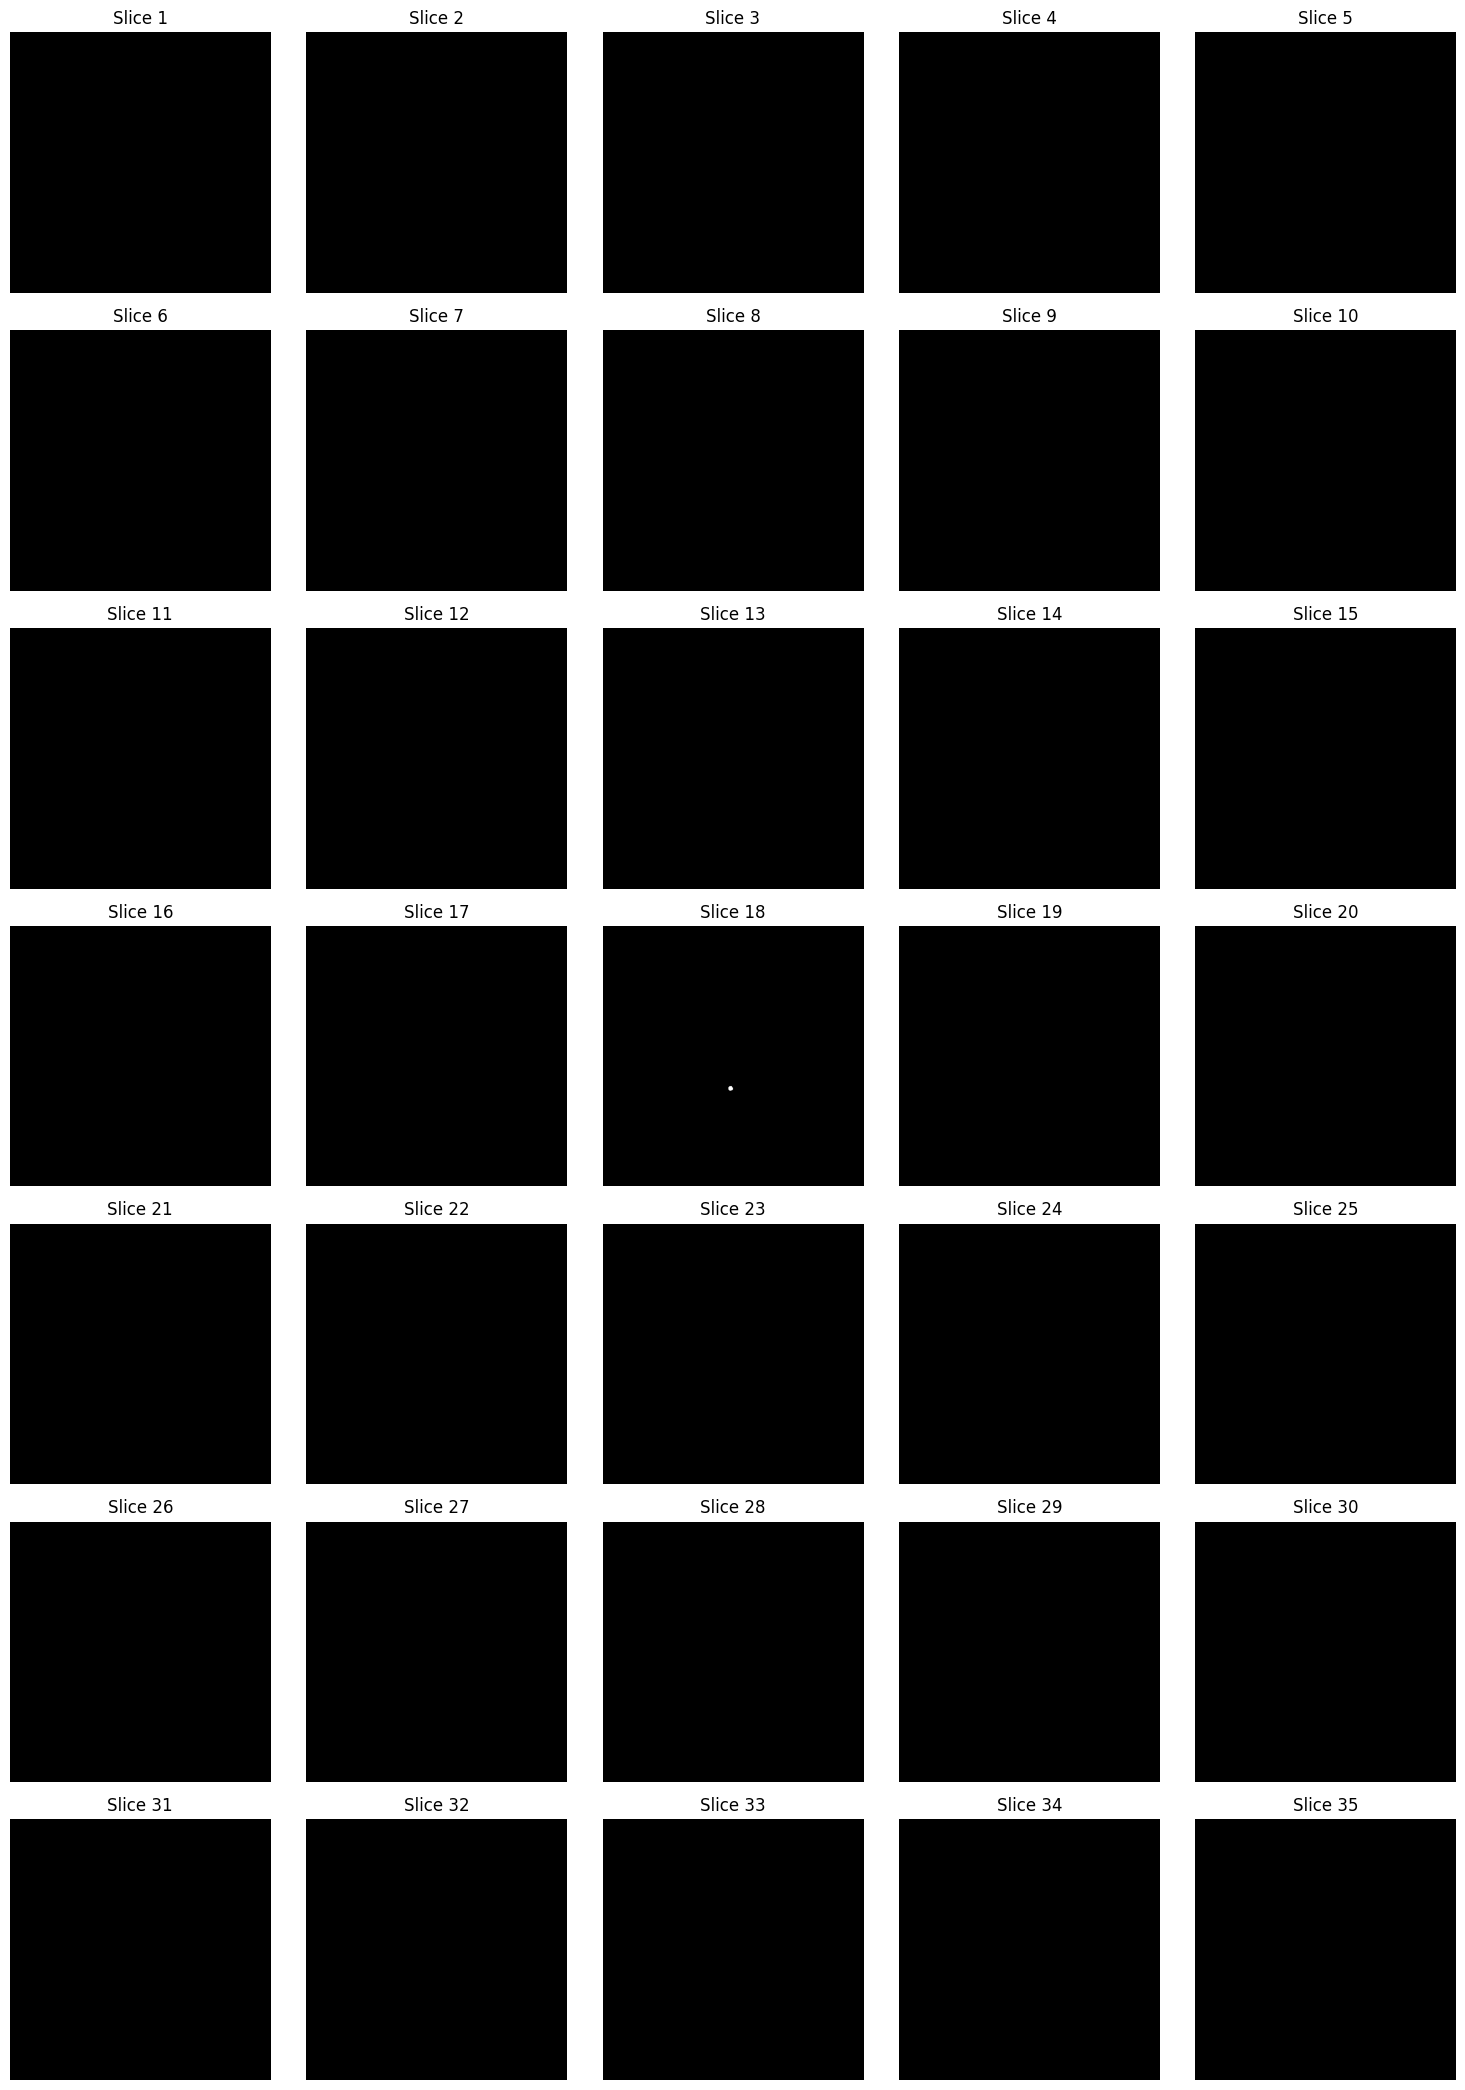

In [41]:
plot_all_slices(masks[1])